# EDA 001 - Study on reference coordiante system

As there are multiple reference systems between SimpleITK, VTK and numpy, one has to be really sure whenever transforming images or fields between them. To that end, I will use a couple of simple examples and then more complicated ones to understand the relationships and mechanisms behind this issue.

## Objectives 📋

This notebook aims to:
- Generate a trivial example of an image and a transformation with numpy
- Transform it with SITK to see the difference with their coordinate systems

## Imports ⚙️

In [7]:
import numpy as np
import SimpleITK as sitk
from tvtk.api import tvtk
import matplotlib.pyplot as plt

## Data loading 📈

The first experiment we're conducting will consist on a simple example, a centered 16x16 square in a 64x32 image:

$$I =\begin{cases} 1 &\text{ if }(x,y) \in [16,32]\times[16,32]\\ 0 &\text{ otherwise.}\end{cases}$$

with a tranformation given by:

$$T(x,y) = (0,5)\quad \forall (x,y)\in I$$

This should move the square more in the $y$ direction than in the $x$ direction.



In [8]:
image = np.zeros((64,32))
transform = np.zeros((64,32,2))
transform[..., 1] = 5
image[16:32, 16:32] = 1


## Analysis 👨‍🔬

Now we will create a _naive_ approach to the transform: we will simply pass our numpy 2D array to SimpleITK to generate a `DisplacementFieldTransform` object.

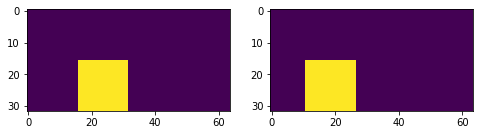

In [9]:
displacement_image = sitk.GetImageFromArray(transform, isVector=True)
sitk_image = sitk.GetImageFromArray(image)
tx = sitk.DisplacementFieldTransform(displacement_image)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(sitk_image)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(tx)
regmov = resampler.Execute(sitk_image)

fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(image.T)
axs[1].imshow(sitk.GetArrayFromImage(regmov).T)
plt.show()

As we can see, the image is moved mostly in the x-axis, to the negative direction. This means:
1. If it's moving in the negative direction, that means it's using some sort of _inverse_ transform, not $F\to M$, but $M\to F$.
2. The direction must be rotated 90 degrees.

To correct this issues, I will try to swap axes and use the inverse transform. In this case it's easy, it's just a minus sign.

In [10]:
corrected_transform = np.zeros_like(transform)
corrected_transform[..., 0] = -transform[..., 1]
corrected_transform[..., 1] = -transform[..., 0]

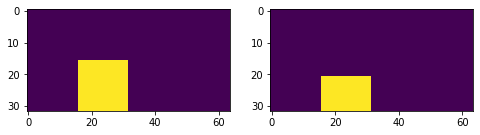

In [11]:
displacement_image = sitk.GetImageFromArray(corrected_transform, isVector=True)
sitk_image = sitk.GetImageFromArray(image)
tx = sitk.DisplacementFieldTransform(displacement_image)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(sitk_image)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(tx)
regmov = resampler.Execute(sitk_image)

fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(image.T)
axs[1].imshow(sitk.GetArrayFromImage(regmov).T)
plt.show()

Much better! Now we have an upwards-y-axis movement, which is what we expected.

## Conclusions 💡
- SimpleITK has a not-so-comfortable transform reference system.
- It uses a $F\to M$ transform mechanism.
- Axis from Numpy images must be swapped.